In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import sys
from adjustText import adjust_text

# Import functions from analyze_results.py
from analyze_results import (
    load_results,
    compute_iteration_accuracy,
    compute_best_so_far_accuracy,
    compute_conditional_probabilities,
    plot_accuracy_curves,
    find_transition_examples
)

# Self-Refine Results Analysis

This notebook analyzes self-refine results across different models and tasks.

## Structure:
1. **Load Results** - Loads all available result files
2. **Per-Model Plots** - Separate plots for each model showing both tasks side-by-side
3. **Individual Plots** - One plot per setting (model + task combination)
4. **Summary Statistics** - Detailed statistics for all settings
5. **Conditional Probabilities** - Analysis of transition probabilities
   - P(correct_{i+1} | correct_i) - Answer stability
   - P(correct_{i+1} | incorrect_i) - Refinement improvement
6. **Summary Table** - Key metrics comparison

## Key Metrics:
- **Accuracy at iteration i**: Performance at each specific iteration
- **Best accuracy so far**: Marks example correct if correct in ≥1 iteration up to i
- **Stability**: How often correct answers stay correct after refinement
- **Refinement Help**: How often incorrect answers become correct after refinement

## Outputs:
**Per-model comparisons:**
- `results/qwen3-0_6b_comparison.png` - Qwen3-0.6B both tasks
- `results/qwen3-4b_comparison.png` - Qwen3-4B both tasks

**Individual accuracy plots:**
- `results/qwen3-0_6b_graph.png`, `results/qwen3-0_6b_mmlu.png`
- `results/qwen3-4b_graph.png`, `results/qwen3-4b_mmlu.png`

**Conditional probability plots (per setting):**
- `results/qwen3-0_6b_graph_cond_probs.png`, etc.

**Conditional probability comparisons (per task, comparing models):**
- `results/conditional_probs_graph.png` - Compares models on Graph task
- `results/conditional_probs_mmlu.png` - Compares models on MMLU task

Run cells as results become available!

In [2]:
temp_low = load_results("../results/temp_comparison_low.json")
temp_default = load_results("../results/temp_comparison_default.json")

In [3]:
def compute_best_so_far(results):
    best_accuracies = {}
    num_iterations = len(results[0]['iterations']) if results else 0
    
    for i in range(num_iterations):
        correct = sum(1 for r in results 
                     if any(r['iterations'][j]['is_correct'] for j in range(i+1)))
        best_accuracies[i+1] = correct / len(results) if results else 0
    
    return best_accuracies

In [4]:
best_low = compute_best_so_far(temp_low)
best_default = compute_best_so_far(temp_default)

In [5]:
best_low

{1: 0.7666666666666667, 2: 0.8, 3: 0.8666666666666667, 4: 0.9}

In [6]:
best_default

{1: 0.7666666666666667,
 2: 0.8333333333333334,
 3: 0.8666666666666667,
 4: 0.8666666666666667}

## Performance 

In [7]:
# Load all results (2 models x 2 tasks = 4 settings)

results_files = {
    'Qwen3-0.6B (Graph)': '../results/graph_qwen3-0.6b.json',
    'Qwen3-4B (Graph)': '../results/graph_qwen3-4b.json',
    'Qwen3-0.6B (MMLU)': '../results/mmlu_qwen3-0.6b.json',
    'Qwen3-4B (MMLU)': '../results/mmlu_qwen3-4b.json',
}

all_results = {}
for name, filepath in results_files.items():
    try:
        all_results[name] = load_results(filepath)
        print(f"✓ Loaded {name}: {len(all_results[name])} examples")
    except FileNotFoundError:
        print(f"✗ File not found: {filepath}")
        
print(f"\nTotal loaded: {len(all_results)} settings")

✓ Loaded Qwen3-0.6B (Graph): 100 examples
✓ Loaded Qwen3-4B (Graph): 100 examples
✓ Loaded Qwen3-0.6B (MMLU): 100 examples
✓ Loaded Qwen3-4B (MMLU): 100 examples

Total loaded: 4 settings


✓ Saved plot to ../results/qwen3-0_6b_comparison.pdf


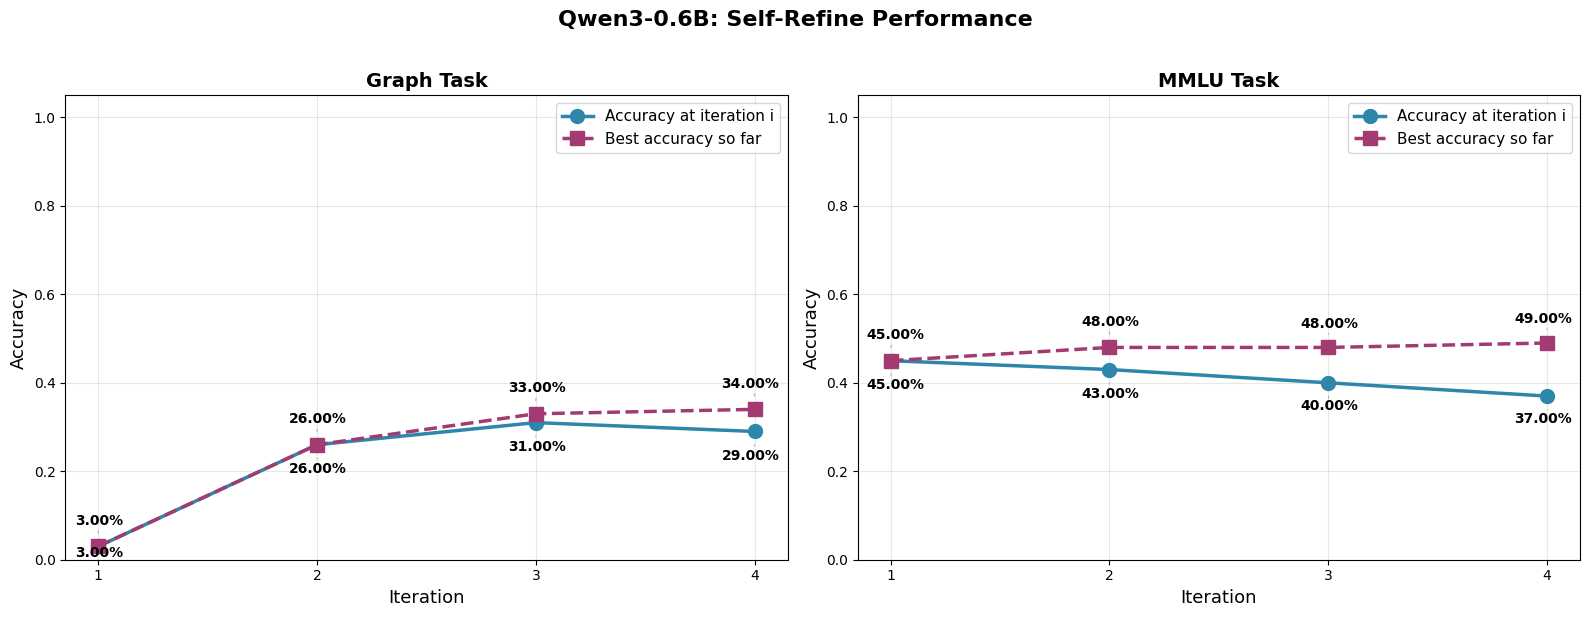

✓ Saved plot to ../results/qwen3-4b_comparison.pdf


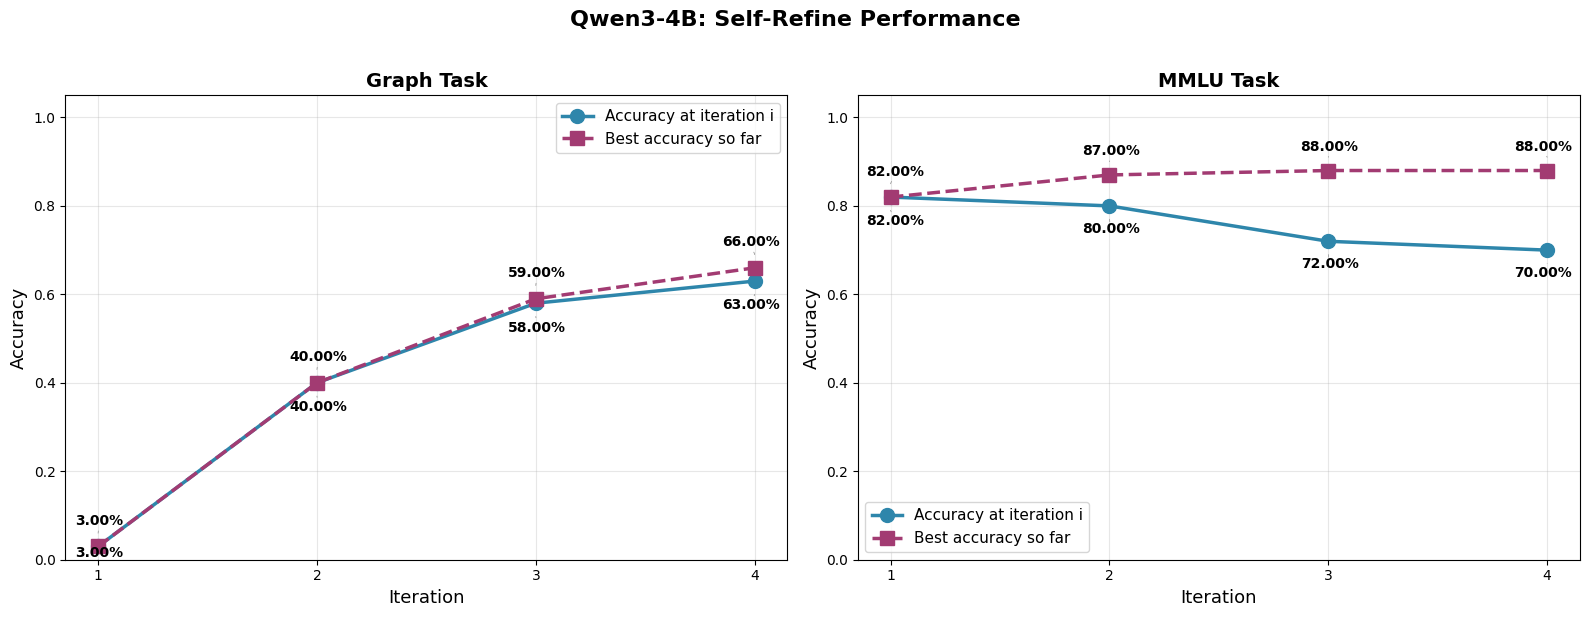

In [8]:
# Separate plots for each model

models = ['Qwen3-0.6B', 'Qwen3-4B']

for model_name in models:
    # Get results for this model (both tasks)
    model_results = {k: v for k, v in all_results.items() if model_name in k}
    
    if not model_results:
        print(f"No results found for {model_name}")
        continue
    
    # Create figure with subplots for each task
    fig, axes = plt.subplots(1, len(model_results), figsize=(8*len(model_results), 6))
    if len(model_results) == 1:
        axes = [axes]  # Make it iterable
    
    for idx, (name, results) in enumerate(model_results.items()):
        ax = axes[idx]
        
        # Compute accuracies
        iter_acc = compute_iteration_accuracy(results)
        best_acc = compute_best_so_far_accuracy(results)
        
        iterations = sorted(iter_acc.keys())
        iter_values = [iter_acc[i] for i in iterations]
        best_values = [best_acc[i] for i in iterations]
        
        # Plot
        ax.plot(iterations, iter_values, 'o-', label='Accuracy at iteration i', 
                linewidth=2.5, markersize=10, color='#2E86AB')
        ax.plot(iterations, best_values, 's--', label='Best accuracy so far', 
                linewidth=2.5, markersize=10, color='#A23B72')
        
        ax.set_xlabel('Iteration', fontsize=13)
        ax.set_ylabel('Accuracy', fontsize=13)
        
        # Extract task name
        task_name = 'Graph' if 'Graph' in name else 'MMLU'
        ax.set_title(f'{task_name} Task', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(iterations)
        ax.set_ylim([0, 1.05])
        
        texts = []
        for i, (iter_v, best_v) in enumerate(zip(iter_values, best_values), 1):
            # Place labels based on which value is higher to avoid overlap
            if iter_v > best_v:
                # iter_v is higher, put it above and best_v below
                texts.append(ax.text(i, iter_v + 0.03, f'{iter_v:.2%}',
                                    ha='center', va='bottom', fontsize=10, fontweight='bold'))
                texts.append(ax.text(i, best_v - 0.03, f'{best_v:.2%}',
                                    ha='center', va='top', fontsize=10, fontweight='bold'))
            else:
                # best_v is higher or equal, put it above and iter_v below
                texts.append(ax.text(i, best_v + 0.03, f'{best_v:.2%}',
                                    ha='center', va='bottom', fontsize=10, fontweight='bold'))
                texts.append(ax.text(i, iter_v - 0.03, f'{iter_v:.2%}',
                                    ha='center', va='top', fontsize=10, fontweight='bold'))

        # after adding all texts:
        adjust_text(texts, ax=ax, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
        
    plt.suptitle(f'{model_name}: Self-Refine Performance', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save plot
    filename = f'../results/{model_name.lower().replace(".", "_")}_comparison.pdf'
    plt.savefig(filename, bbox_inches='tight')
    print(f"✓ Saved plot to {filename}")
    plt.show()


In [9]:
# Print Summary Statistics for All Settings
for name, results in all_results.items():
    print(f"\n{'='*70}")
    print(f"{name}")
    print(f"{'='*70}")
    
    iter_acc = compute_iteration_accuracy(results)
    best_acc = compute_best_so_far_accuracy(results)
    
    print("\nAccuracy at each iteration:")
    for i, acc in iter_acc.items():
        correct = int(acc * len(results))
        print(f"  Iteration {i}: {correct}/{len(results)} = {acc:.2%}")
    
    print("\nBest accuracy so far:")
    for i, acc in best_acc.items():
        correct = int(acc * len(results))
        print(f"  Up to Iteration {i}: {correct}/{len(results)} = {acc:.2%}")
    
    # Improvement from iteration 1 to 4
    improvement = best_acc[4] - iter_acc[1]
    print(f"\nImprovement (best@4 - iter@1): {improvement:+.2%}")



Qwen3-0.6B (Graph)

Accuracy at each iteration:
  Iteration 1: 3/100 = 3.00%
  Iteration 2: 26/100 = 26.00%
  Iteration 3: 31/100 = 31.00%
  Iteration 4: 28/100 = 29.00%

Best accuracy so far:
  Up to Iteration 1: 3/100 = 3.00%
  Up to Iteration 2: 26/100 = 26.00%
  Up to Iteration 3: 33/100 = 33.00%
  Up to Iteration 4: 34/100 = 34.00%

Improvement (best@4 - iter@1): +31.00%

Qwen3-4B (Graph)

Accuracy at each iteration:
  Iteration 1: 3/100 = 3.00%
  Iteration 2: 40/100 = 40.00%
  Iteration 3: 57/100 = 58.00%
  Iteration 4: 63/100 = 63.00%

Best accuracy so far:
  Up to Iteration 1: 3/100 = 3.00%
  Up to Iteration 2: 40/100 = 40.00%
  Up to Iteration 3: 59/100 = 59.00%
  Up to Iteration 4: 66/100 = 66.00%

Improvement (best@4 - iter@1): +63.00%

Qwen3-0.6B (MMLU)

Accuracy at each iteration:
  Iteration 1: 45/100 = 45.00%
  Iteration 2: 43/100 = 43.00%
  Iteration 3: 40/100 = 40.00%
  Iteration 4: 37/100 = 37.00%

Best accuracy so far:
  Up to Iteration 1: 45/100 = 45.00%
  Up to It

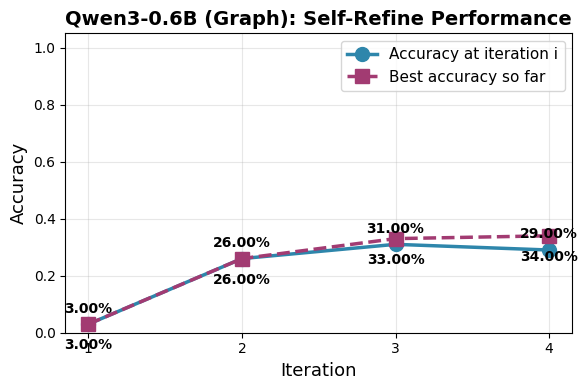

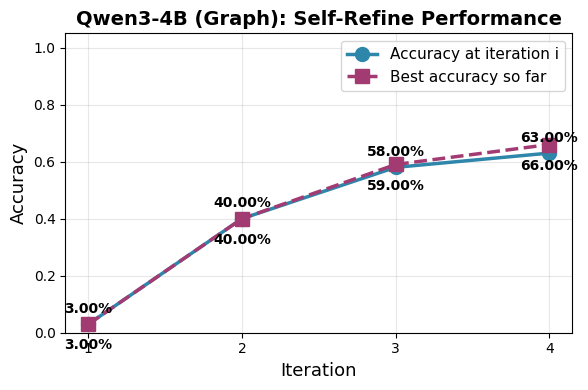

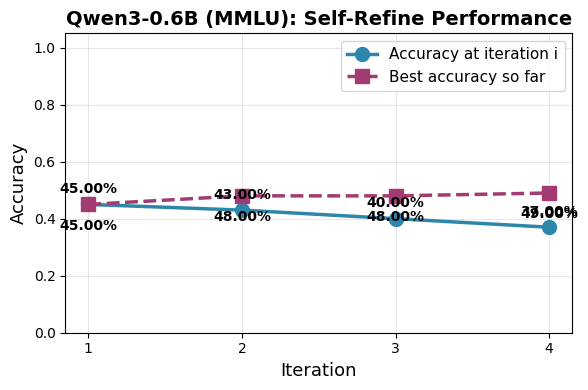

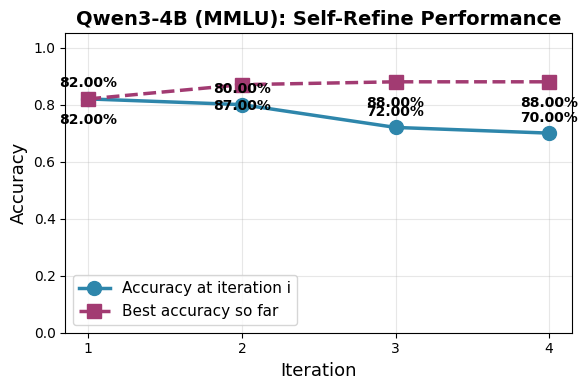

In [10]:
# Individual plots for each setting (model + task)

for name, results in all_results.items():
    # Compute accuracies
    iter_acc = compute_iteration_accuracy(results)
    best_acc = compute_best_so_far_accuracy(results)
    
    iterations = sorted(iter_acc.keys())
    iter_values = [iter_acc[i] for i in iterations]
    best_values = [best_acc[i] for i in iterations]
    
    # Create plot
    plt.figure(figsize=(6, 4))
    plt.plot(iterations, iter_values, 'o-', label='Accuracy at iteration i', 
             linewidth=2.5, markersize=10, color='#2E86AB')
    plt.plot(iterations, best_values, 's--', label='Best accuracy so far', 
             linewidth=2.5, markersize=10, color='#A23B72')
    
    plt.xlabel('Iteration', fontsize=13)
    plt.ylabel('Accuracy', fontsize=13)
    plt.title(f'{name}: Self-Refine Performance', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.xticks(iterations)
    plt.ylim([0, 1.05])
    
    # Add value labels on points
    for i, (iter_v, best_v) in enumerate(zip(iter_values, best_values), 1):
        plt.text(i, iter_v + 0.03, f'{iter_v:.2%}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
        plt.text(i, best_v - 0.05, f'{best_v:.2%}', ha='center', va='top', 
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save plot
#     filename = f'../results/{name.lower().replace(" ", "_").replace("(", "").replace(")", "")}.png'
#     plt.savefig(filename, dpi=300, bbox_inches='tight')
#     print(f"✓ Saved plot to {filename}")
#     plt.show()


✓ Saved conditional probability plot to ../results/qwen3-0.6b_graph_cond_probs.png


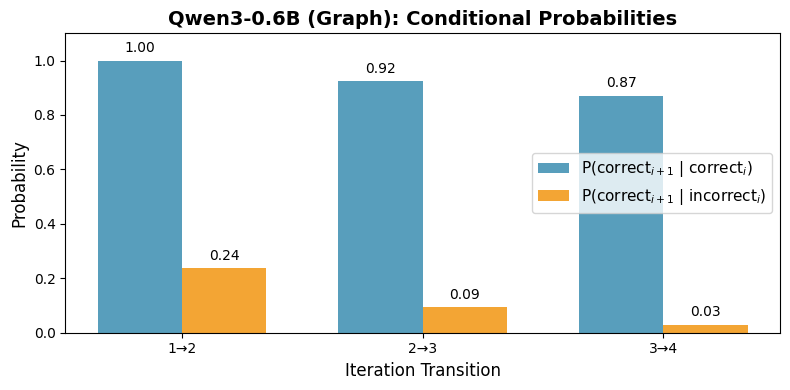

✓ Saved conditional probability plot to ../results/qwen3-4b_graph_cond_probs.png


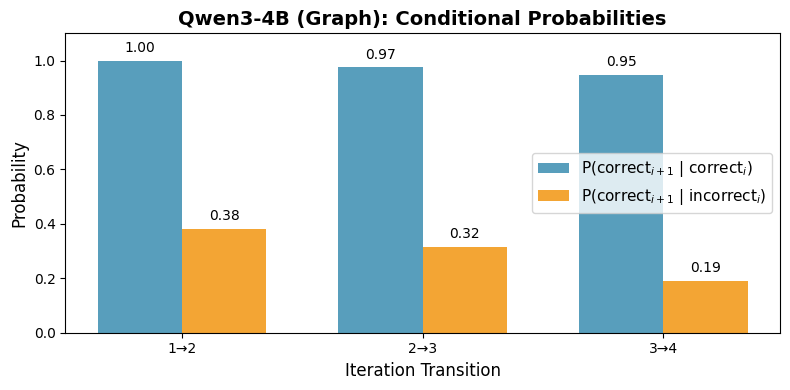

✓ Saved conditional probability plot to ../results/qwen3-0.6b_mmlu_cond_probs.png


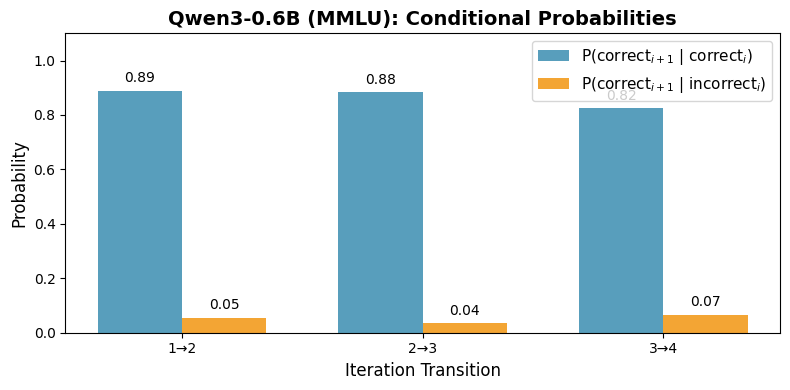

✓ Saved conditional probability plot to ../results/qwen3-4b_mmlu_cond_probs.png


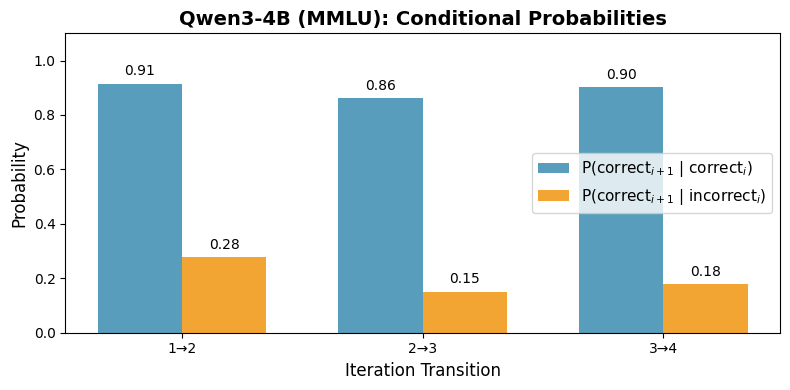

In [11]:
# Visualize Conditional Probabilities
for name, results in all_results.items():
    cond_probs = compute_conditional_probabilities(results)
    
    iterations = list(range(1, len(cond_probs['p_correct_given_correct']) + 1))
    p_cc = cond_probs['p_correct_given_correct']
    p_ic = cond_probs['p_correct_given_incorrect']
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(8, 4))
    x_labels = [f'{i}→{i+1}' for i in iterations]
    x_pos = np.arange(len(x_labels))
    
    width = 0.35
    bars1 = ax.bar(x_pos - width/2, p_cc, width, label='P(correct$_{i+1}$ | correct$_i$)', 
                   alpha=0.8, color='#2E86AB')
    bars2 = ax.bar(x_pos + width/2, p_ic, width, label='P(correct$_{i+1}$ | incorrect$_i$)', 
                   alpha=0.8, color='#F18F01')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_xlabel('Iteration Transition', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    ax.set_title(f'{name}: Conditional Probabilities', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels)
    ax.legend(fontsize=11, loc='best')
    # ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
    
    plt.tight_layout()
    
    # Save plot
    filename = f'../results/{name.lower().replace(" ", "_").replace("(", "").replace(")", "")}_cond_probs.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved conditional probability plot to {filename}")
    plt.show()


✓ Saved Graph conditional probabilities to ../results/conditional_probs_graph.pdf


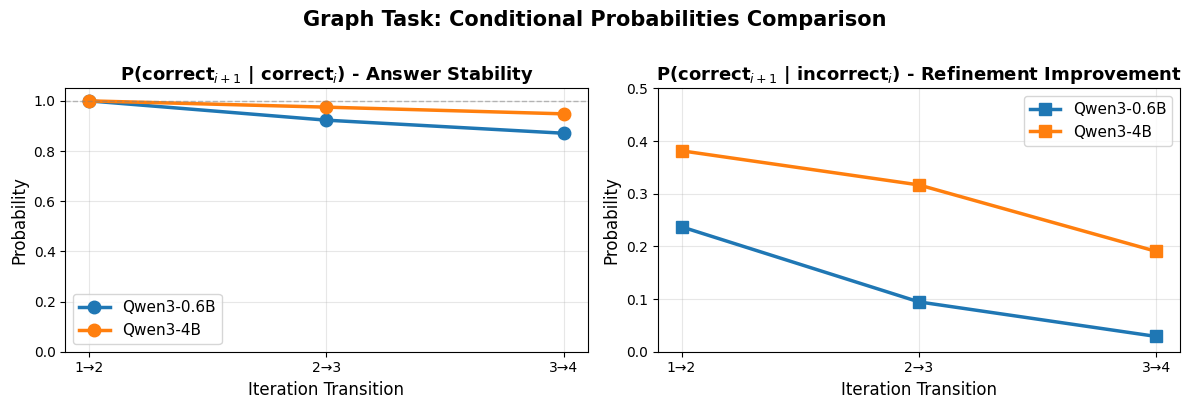

✓ Saved MMLU conditional probabilities to ../results/conditional_probs_mmlu.pdf


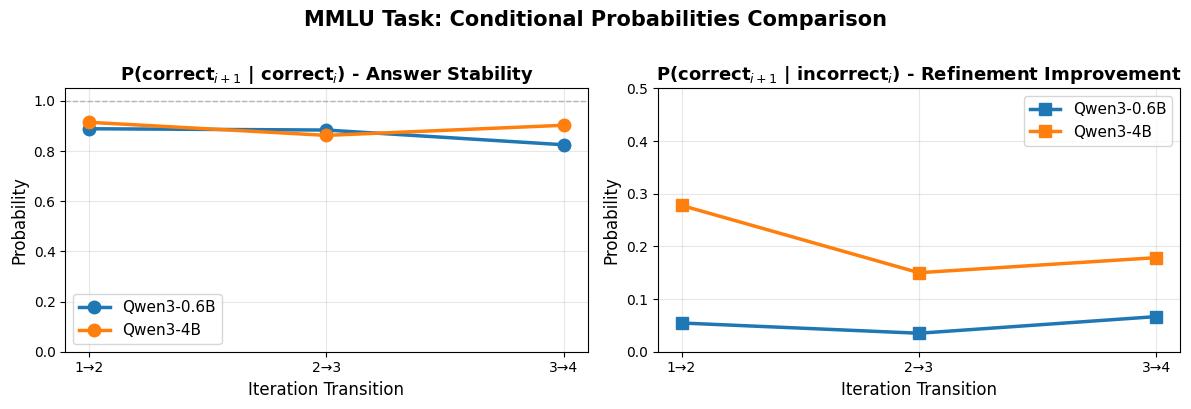

In [12]:
# Comparison of Conditional Probabilities - Separated by Task

tasks = ['Graph', 'MMLU']

for task in tasks:
    # Filter results for this task
    task_results = {k: v for k, v in all_results.items() if task in k}
    
    if not task_results:
        print(f"No results found for {task} task")
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 1: P(correct_{i+1} | correct_i) - Stability
    ax = axes[0]
    for name, results in task_results.items():
        cond_probs = compute_conditional_probabilities(results)
        if not cond_probs['p_correct_given_correct']:
            continue
        
        iterations = list(range(1, len(cond_probs['p_correct_given_correct']) + 1))
        x_labels = [f'{i}→{i+1}' for i in iterations]
        p_cc = cond_probs['p_correct_given_correct']
        
        # Extract model name for legend
        model_name = name.split(' (')[0]
        ax.plot(iterations, p_cc, 'o-', label=model_name, linewidth=2.5, markersize=9)
    
    ax.set_xlabel('Iteration Transition', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    ax.set_title('P(correct$_{i+1}$ | correct$_i$) - Answer Stability', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(iterations)
    ax.set_xticklabels(x_labels)
    ax.set_ylim([0, 1.05])
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Plot 2: P(correct_{i+1} | incorrect_i) - Improvement
    ax = axes[1]
    for name, results in task_results.items():
        cond_probs = compute_conditional_probabilities(results)
        if not cond_probs['p_correct_given_incorrect']:
            continue
        
        iterations = list(range(1, len(cond_probs['p_correct_given_incorrect']) + 1))
        x_labels = [f'{i}→{i+1}' for i in iterations]
        p_ic = cond_probs['p_correct_given_incorrect']
        
        # Extract model name for legend
        model_name = name.split(' (')[0]
        ax.plot(iterations, p_ic, 's-', label=model_name, linewidth=2.5, markersize=9)
    
    ax.set_xlabel('Iteration Transition', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    ax.set_title('P(correct$_{i+1}$ | incorrect$_i$) - Refinement Improvement', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(iterations)
    ax.set_xticklabels(x_labels)
    ax.set_ylim([0, max(0.5, max([max(compute_conditional_probabilities(r)['p_correct_given_incorrect']) for r in task_results.values()]) + 0.1)])
    
    plt.suptitle(f'{task} Task: Conditional Probabilities Comparison', fontsize=15, fontweight='bold', y=1.01)
    plt.tight_layout()
    
    filename = f'../results/conditional_probs_{task.lower()}.pdf'
    plt.savefig(filename, bbox_inches='tight')
    print(f"✓ Saved {task} conditional probabilities to {filename}")
    plt.show()


In [13]:
# Summary Table: Key Metrics

data = []
for name, results in all_results.items():
    iter_acc = compute_iteration_accuracy(results)
    best_acc = compute_best_so_far_accuracy(results)
    cond_probs = compute_conditional_probabilities(results)
    
    # Average probabilities across transitions
    avg_p_cc = np.mean(cond_probs['p_correct_given_correct']) if cond_probs['p_correct_given_correct'] else 0
    avg_p_ic = np.mean(cond_probs['p_correct_given_incorrect']) if cond_probs['p_correct_given_incorrect'] else 0
    
    data.append({
        'Setting': name,
        'Initial Acc (Iter 1)': f"{iter_acc[1]:.2%}",
        'Final Acc (Iter 4)': f"{iter_acc[4]:.2%}",
        'Best So Far (Iter 4)': f"{best_acc[4]:.2%}",
        'Improvement': f"{best_acc[4] - iter_acc[1]:+.2%}",
        'Avg Stability': f"{avg_p_cc:.3f}",
        'Avg Refinement Help': f"{avg_p_ic:.3f}",
    })

df = pd.DataFrame(data)
print("\n" + "="*100)
print("SUMMARY TABLE")
print("="*100)
print(df.to_string(index=False))
print("\nNote: Stability = P(correct_{i+1} | correct_i), Refinement Help = P(correct_{i+1} | incorrect_i)")



SUMMARY TABLE
           Setting Initial Acc (Iter 1) Final Acc (Iter 4) Best So Far (Iter 4) Improvement Avg Stability Avg Refinement Help
Qwen3-0.6B (Graph)                3.00%             29.00%               34.00%     +31.00%         0.931               0.120
  Qwen3-4B (Graph)                3.00%             63.00%               66.00%     +63.00%         0.974               0.296
 Qwen3-0.6B (MMLU)               45.00%             37.00%               49.00%      +4.00%         0.866               0.052
   Qwen3-4B (MMLU)               82.00%             70.00%               88.00%      +6.00%         0.893               0.202

Note: Stability = P(correct_{i+1} | correct_i), Refinement Help = P(correct_{i+1} | incorrect_i)


## Case Studies: Refinement Success and Failure Examples

Finding specific examples where:
1. **Refinement helps**: Incorrect → Correct
2. **Refinement hurts**: Correct → Incorrect

In [14]:
# Find example cases for each dataset

for name, results in all_results.items():
    print("\n" + "="*100)
    print(f"{name}")
    print("="*100)
    
    # Try to find examples across all iteration transitions
    found_improvement = False
    found_degradation = False
    
    for iter_idx in range(3):  # Check iterations 0→1, 1→2, 2→3
        if not found_improvement:
            # Find: Incorrect → Correct (refinement helps)
            improvement_examples = find_transition_examples(results, from_state=False, to_state=True, 
                                                           iteration=iter_idx, limit=1)
            if improvement_examples:
                found_improvement = True
                ex = improvement_examples[0]
                print(f"\n✓ REFINEMENT IMPROVES (Iteration {iter_idx+1} → {iter_idx+2})")
                print(f"  Example ID: {ex['example_id']}")
                print(f"\n  Question (first 300 chars):")
                print(f"  {ex['iteration_i']['raw_response'][:300] if 'raw_response' in ex['iteration_i'] else ex['question'][:300]}...")
                print(f"\n  Iteration {iter_idx+1} (INCORRECT):")
                print(f"    Parsed Answer: {ex['iteration_i']['parsed_answer']}")
                print(f"\n  Iteration {iter_idx+2} (CORRECT):")
                print(f"    Parsed Answer: {ex['iteration_i_plus_1']['parsed_answer']}")
        
        if not found_degradation:
            # Find: Correct → Incorrect (refinement hurts)
            degradation_examples = find_transition_examples(results, from_state=True, to_state=False, 
                                                           iteration=iter_idx, limit=1)
            if degradation_examples:
                found_degradation = True
                ex = degradation_examples[0]
                print(f"\n✗ REFINEMENT HURTS (Iteration {iter_idx+1} → {iter_idx+2})")
                print(f"  Example ID: {ex['example_id']}")
                print(f"\n  Question (first 300 chars):")
                print(f"  {ex['iteration_i']['raw_response'][:300] if 'raw_response' in ex['iteration_i'] else ex['question'][:300]}...")
                print(f"\n  Iteration {iter_idx+1} (CORRECT):")
                print(f"    Parsed Answer: {ex['iteration_i']['parsed_answer']}")
                print(f"\n  Iteration {iter_idx+2} (INCORRECT):")
                print(f"    Parsed Answer: {ex['iteration_i_plus_1']['parsed_answer']}")
    
    if not found_improvement:
        print("\n No examples found where refinement improves an incorrect answer")
    if not found_degradation:
        print("\n No examples found where refinement hurts a correct answer")



Qwen3-0.6B (Graph)

✓ REFINEMENT IMPROVES (Iteration 1 → 2)
  Example ID: 4

  Question (first 300 chars):
  <think>
Okay, let's try to solve this problem. We need to find the top 1 shortest path from node 0 to node 4 in this directed graph. The edges have different weights, so I think I need to use Dijkstra's algorithm here because it's a weighted graph and we want the shortest paths.

First, let me list ...

  Iteration 1 (INCORRECT):
    Parsed Answer: {'paths': [], 'weights': []}

  Iteration 2 (CORRECT):
    Parsed Answer: {'paths': [[0, 1, 4], [0, 1, 4]], 'weights': [580, 580]}

✗ REFINEMENT HURTS (Iteration 2 → 3)
  Example ID: 15

  Question (first 300 chars):
  <think>
Okay, let's try to figure out the shortest paths from node 0 to node 2 in the given graph. The graph has three nodes: 0, 1, and 2. The edges and their weights are:

- 0 → 1 (292)
- 0 → 2 (82)
- 1 → 2 (21)
- 1 → 0 (289)
- 2 → 0 (290)
- 2 → 1 (37)

First, I need to find all possible paths from...

  Iteration 2 (

In [15]:
# Detailed view: Export full examples for manual inspection

def show_full_example(results, example_id):
    """Display full details of a specific example."""
    for r in results:
        if r['example_id'] == example_id:
            print(f"\n{'='*100}")
            print(f"EXAMPLE {example_id} - FULL DETAILS")
            print(f"{'='*100}")
            print(f"\nQuestion:\n{r['question']}\n")
            print(f"Ground Truth: {r['ground_truth']}\n")
            
            for it in r['iterations']:
                print(f"\n{'-'*100}")
                print(f"Iteration {it['iteration']} ({it['type']}): {'✓ CORRECT' if it['is_correct'] else '✗ INCORRECT'}")
                print(f"{'-'*100}")
                print(f"Parsed Answer: {it['parsed_answer']}")
                print(f"\nRaw Response:\n{it['raw_response']}...")
                if 'feedback' in it and it['feedback']:
                    print(f"\nFeedback:\n{it['feedback']}...")
            return
    print(f"Example {example_id} not found")

# Example usage - uncomment and modify example_id to see full details:
# show_full_example(all_results['Qwen3-0.6B (Graph)'], example_id=0)
